# Titanic dataset
W tym notebook'u postaram się wytrenować model, który będzie w stanie odgadnąć, czy dana osoba przeżyła katastrofę Titanic'a na podstawie różnych danych na temat tej osoby.

## 1. Importowanie zależności
Żeby wykonać to zadanie, będę potrzebował kilku zależności, takich jak pandas, numpy, czy matplotlib (żeby zwizualizować dane)

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

## 2. Załadowanie danych
Aby załadować potrzebne mi dane, posłużę się danymi udostępnionymi przez [Kaggle](https://www.kaggle.com/c/titanic/data). Ładuję jedynie dane treningowe, ponieważ dla danych testowych, Kaggle nie podaje nam target feature (o to chodzi w konkursie). W dalszej części podzielę dane treningowe na 2 zbiory, żeby móc zwalidować model.

In [2]:
train = pd.read_csv('train.csv')

## 3. Eksploracja danych
Jeżeli mamy już potrzebne dane, to warto by było bliżej im się przyjrzeć, żeby wiedzieć, z czym będziemy pracować.

In [3]:
train.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
326,327,0,3,"Nysveen, Mr. Johan Hansen",male,61.0,0,0,345364,6.2375,NaN,S
415,416,0,3,"Meek, Mrs. Thomas (Annie Louise Rowley)",female,NaN,0,0,343095,8.0500,NaN,S
858,859,1,3,"Baclini, Mrs. Solomon (Latifa Qurban)",female,24.0,0,3,2666,19.2583,NaN,C
206,207,0,3,"Backstrom, Mr. Karl Alfred",male,32.0,1,0,3101278,15.8500,NaN,S
337,338,1,1,"Burns, Miss. Elizabeth Margaret",female,41.0,0,0,16966,134.5000,E40,C
514,515,0,3,"Coleff, Mr. Satio",male,24.0,0,0,349209,7.4958,NaN,S
384,385,0,3,"Plotcharsky, Mr. Vasil",male,NaN,0,0,349227,7.8958,NaN,S
393,394,1,1,"Newell, Miss. Marjorie",female,23.0,1,0,35273,113.2750,D36,C
238,239,0,2,"Pengelly, Mr. Frederick William",male,19.0,0,0,28665,10.5000,NaN,S
674,675,0,2,"Watson, Mr. Ennis Hastings",male,NaN,0,0,239856,0.0000,NaN,S


Oprócz oczywistych danych, takich jak `PassengerId, Survived, Name, etc.`, znajduje się kilka bardziej "tajemniczych" nazw kolumn. Sprawdzając to na Kaggle, dowiadujemy się, że:

***pclass*** - jest to oznaczenie klasy socjo-ekonomicznej danego pasażera, gdzie:
    - 1 = klasa wyższa
    - 2 = klasa średnia
    - 3 = klasa niższa
    
***parch*** - oznacza relację rodzić-dziecko (innymi słowy, w przypadku dorosłego, z iloma dziećmi podróżował, a w przypadku dzieci - ilu rodziców podróżowało z tym dzieckiem. Niektóre dzieci podróżowały z opiekunkami - dla nich wartość tej kolumny wynosi 0)

***sibsp*** - oznacza relację rodzeństwo-małżonek/małżonka (podobnie jak w przypadku parch). Narzeczeni lub "nieformalni" partnerzy nie byli brani pod uwagę.

***embarked*** - nazwa portu, z którego dany pasażer wyruszył w podróż (C = Cherbourg, Q = Queenstown, S = Southampton)


Sprawdźmy nasze dane nieco dokładniej

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Najistotniejszą rzeczą, którą można wywnioskować z powyższych informacji jest to, że mamy puste wartości w kolumnach **Age** i **Cabin**. Rozwiążemy tę sytuację podstawiając w miejsce pustych wartości *-1*.

In [6]:
train.fillna(-1, inplace=True)
train.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
299,300,1,1,"Baxter, Mrs. James (Helene DeLaudeniere Chaput)",female,50.0,0,1,PC 17558,247.5208,B58 B60,C
846,847,0,3,"Sage, Mr. Douglas Bullen",male,-1.0,8,2,CA. 2343,69.5500,-1,S
220,221,1,3,"Sunderland, Mr. Victor Francis",male,16.0,0,0,SOTON/OQ 392089,8.0500,-1,S
743,744,0,3,"McNamee, Mr. Neal",male,24.0,1,0,376566,16.1000,-1,S
440,441,1,2,"Hart, Mrs. Benjamin (Esther Ada Bloomfield)",female,45.0,1,1,F.C.C. 13529,26.2500,-1,S
623,624,0,3,"Hansen, Mr. Henry Damsgaard",male,21.0,0,0,350029,7.8542,-1,S
391,392,1,3,"Jansson, Mr. Carl Olof",male,21.0,0,0,350034,7.7958,-1,S
390,391,1,1,"Carter, Mr. William Ernest",male,36.0,1,2,113760,120.0000,B96 B98,S
321,322,0,3,"Danoff, Mr. Yoto",male,27.0,0,0,349219,7.8958,-1,S
69,70,0,3,"Kink, Mr. Vincenz",male,26.0,2,0,315151,8.6625,-1,S


Jak widać powyżej - puste wartości zostały zatąpione przez *-1*. W ten sposób model nie pomyli ich z innymi wartościami dostępnymi w tym dataset'cie

Wygodniej by było, gdybyśmy jeszcze ustandaryzowali sobie nazwy kolumn. Zamieńmy nazwy kolumn w dataset'cie z `camelCase` na `snake_case`. Wykorzystam do tego bibliotekę `stringcase`, którą wcześniej zainstalowałem za pomocą komendy `pip install stringcase`

In [7]:
from stringcase import snakecase

In [8]:
train.rename(columns=lambda x: snakecase(x), inplace=True)

In [9]:
train.sample()

,passenger_id,survived,pclass,name,sex,age,sib_sp,parch,ticket,fare,cabin,embarked
868,869,0,3,"van Melkebeke, Mr. Philemon",male,-1.0,0,0,345777,9.5,-1,S


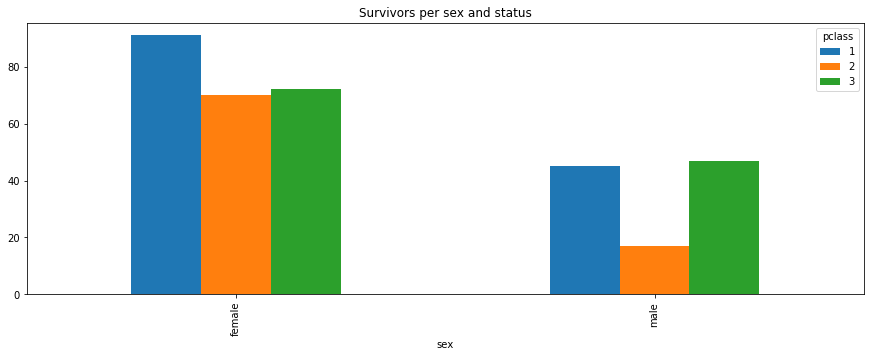

In [10]:
survivors = train[train['survived'] == 1]
grouped = survivors.groupby(['sex', 'pclass'])['survived'].agg('sum').unstack()
grouped.plot(kind='bar', figsize=(15, 5), title='Survivors per sex and status');

## 4. Zdefiniowanie natury problemu
Ten krok w zasadzie powinien być jednym z pierwszych, ale w tym przypadku nasz problem ma dosyć jasną metrykę sukcesu. Chcemy **zaklasyfikować** każdego z pasażerów jako osobę, która przeżyła katastrofę lub która nie przeżyła. Jest to klasyfikacja binarna. Na początek sprawdzę, jak poradzi sobię *DecisionTreeClassifier*, jednak zanim to zrobię, warto byłoby nieco ustandaryzować nasze dane i spróbować dodać kilka nowych cech.

## 5. Standaryzowanie danych i feature engineering

## 6. Podział danych i trenowanie modelu

In [11]:
X = train.drop('survived', axis=1)
y = train['survived']
X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=0.3)

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy_score(y_test, y_pred)